In [62]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from make_map import make_map

from file_util import load_matlab_data
from channel_overlap import *
from plot import plot_discharge
from metrics import *
from stratigraphy import *
from spatial_dist import *
from profiles import *
from make_pretty_images import *

  
import cPickle as pickle

In [63]:
TH_TOPO = -0.5
TH_ANGLE = 75
TH_VEL = 0.3 # threshold value for mud deposition from model (U_dep_mud)


'''
Variables for constructing filenames
'''
fbase = 'baseF25data'
froot = '../JGR2016_data/'
sroot = 'mapfiles/'

In [76]:
'''
#########################################################

Metrics for individual timeslices

#########################################################
'''

for fnum in range(4099,4100):

    
    '''
    Load the data into a dictionary of numpy arrays
    Expected keys: ['h', 'uw', 'eta', 'strata', 'qw']
    
    '''
    
    fname = fbase + str(fnum)
    data = load_matlab_data(froot, fname)
    
    
    
    
    '''
    Metrics from raw quantities
    '''
    
    # Makes pretty RGB image showing topo in grays with water in blue
    topo_IMG = water_RGB_image(data['eta'], data['uw'], data['qw'])
    
    # Creates a new colormap 'eta_cmap' that is good for plotting model topography
    # After running this function, use 'eta_cmap' as any other colormap
    elevation_colormap()
    
    # Creates histogram for given quantity
    bins, hists, cumhist, masks = quantity_histograms(data['eta'],
                                                      min_bin = -3, max_bin = 1, dbin = 0.025,
                                                      radius1 = 3, radius2 = 30, radius3 = 90,
                                                      angle = np.pi/6.)
    
    # Gets slices of topography (in planview) above given elevations above sea level
    slices = slice_topography(data['eta'], [0, 0.25, 0.5])
    
    # Extracts elevation profiles at given radii from source
    rad_profiles = radial_profile(data['eta'], [0.25, 0.5, 0.75])

    # Extracts a longitudinal profile along the main channel
    path_IMG, distance, long_profile = main_channel_path(data['eta'], threshold_value = 1)

    
    '''
    Metrics for stratigraphy
    '''
    
    # Calculate total sediment volumes with optional mask
    dx = 100       # cellsize (to convert from number of cells to area)
    dz = 0.005 * 5 # spacing between saved strata, to go from area to volume
    
    mask = np.ones_like(topo)
    mask[:,:120] = 0

    vol_total, vol_sand, frac_sand = sediment_volumes(data['strata'], dx, dz, mask = mask)
    
    
    # Obtain characteristics of subsurface sediments at given radii from source
    seds = sedimentograph(data['strata'], step_radius = 1)
    
    # Extract vertical slices of stratigraphy at given radii from source
    strata_IMGs = radial_stratigraphy(data['strata'], radii = [0.3, 0.5])
    
    # Calculate autocorrelation of sand bodies in vertical slices of stratigraphy
    sand_corrL, sand_corrW = sand_body_properties(strata_IMGs[0])
    
    
    
    '''
    Create map products from raw quantities
    '''

    mapfile = make_map(data['eta'],
                       data['uw'],
                       topo_threshold = TH_TOPO,
                       angle_threshold = TH_ANGLE,
                       velocity_threshold = TH_VEL,
                       numviews = 5,
                       save_file = True,
                       sroot = sroot,
                       fname = fname)
    
    
    '''
    Metrics calculated from the derived maps
    '''
    
    # Calculates total areas and fractional areas for land types
    frac_areas = fractional_areas(mapfile)
    
    # Gets fractal dimension of channel network
    D_frac = fractal_dimension(mapfile['centerlinemap'])
    
    # Calculates island properties and makes map of edge distances
    island_IMG, island_props, ecdf, edgedist_IMG, edgedist_hist = island_properties(mapfile,
                                                                              smooth = True,
                                                                              properties = True)
    
    
    


Created new colormap 'eta_cmap'


In [81]:
'''
#########################################################

Metrics over time

#########################################################
'''

# Extract changes in channel position over time
filenames = [sroot + fbase + str(i) + '.p' for i in range(4005,4010)]
overlap_IMG, overlap_diff, phi, O_phi, f_R = channel_overlap(filenames)

# Get image of superimposed channels over time range
channel_overlay_IMG = channel_overlay(froot, fbase, (4010,4012))

# Calculate the correlation of channel position over time
remaining_channel_fraction = channel_decay(froot, fbase, (4050,4100), number_of_comparisons = 50, average = True)

# Fit curves to decay data
exponential = channel_decay_curve_fit(remaining_channel_fraction, fit = 'exponential')
harmonic = channel_decay_curve_fit(remaining_channel_fraction, fit = 'harmonic')
linear = channel_decay_curve_fit(remaining_channel_fraction, fit = 'linear')

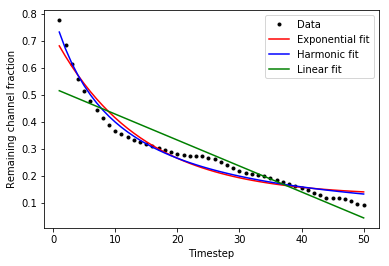

In [83]:
plt.plot(exponential['xdata'], decay, 'k.', label = 'Data')
plt.plot(exponential['xdata'], exponential['fit'], 'r', label = 'Exponential fit')
plt.plot(harmonic['xdata'], harmonic['fit'], 'b', label = 'Harmonic fit')
plt.plot(linear['xdata'], linear['fit'], 'g', label = 'Linear fit')

plt.ylabel('Remaining channel fraction');
plt.xlabel('Timestep');
plt.legend()

In [69]:
from scipy import signal

fname = fbase + str(4100)
data = load_matlab_data(froot, fname)

strata_IMGs = radial_stratigraphy(data['strata'], radii = [0.5], density = 1.5)

In [20]:
A = strata_IMGs[0] > 0.5
A = signal.medfilt2d(A.astype(float), 3)
L, W = A.shape

In [31]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [33]:
a = np.corrcoef(strata_IMGs[0] + 0.0001)
# b = autocorr(strata_IMGs[0])

result = np.correlate(strata_IMGs[0], strata_IMGs[0], mode='full')

ValueError: object too deep for desired array

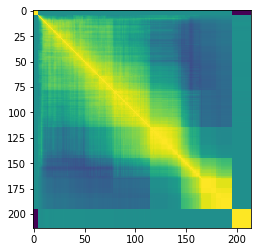

In [28]:
plt.imshow(a)

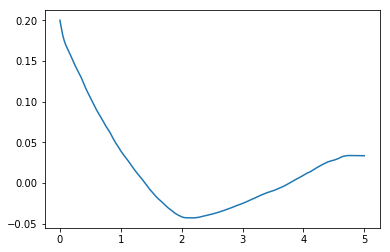

In [5]:
plt.plot(sand_corrL[0], sand_corrL[1])

In [40]:
def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

In [46]:
X = strata_IMGs[0]
y = strata_IMGs[0][100,:]

In [48]:
r = vcorrcoef(X,y)

/Users/mari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


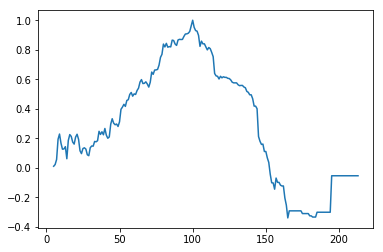

In [49]:
plt.plot(r)

In [50]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

In [53]:
r = corr2_coeff(X,X)

/Users/mari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


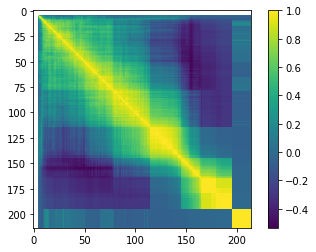

In [55]:
plt.imshow(r)
plt.colorbar()

In [56]:
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

In [58]:
r = generate_correlation_map(X,X)

/Users/mari/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide


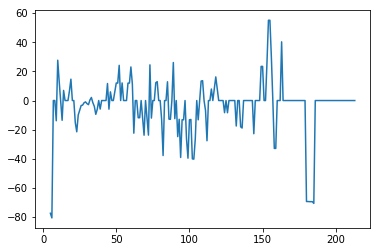

In [61]:
plt.plot(r[:,-10])

In [66]:
difference

array([   0.,  245.,  354.,  438.,  564.])